In [1]:
!pip install numpy
!pip install pandas
!pip install openpyxl
!pip install nltk
!pip install sklearn
!pip install fasttext
!pip install wordcloud
!pip install -U sentence-transformers
!pip install seaborn
!pip install autocorrect
!pip install Unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in

In [2]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [3]:
import os
import numpy as np
import nltk
import pandas as pd
import json
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
from bs4 import BeautifulSoup
from nltk.corpus import stopwords 
from nltk import word_tokenize
import string
import json
import unidecode 
import re 

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## --------------------------- Reading data ---------------------------

In [4]:
# dfs = []
# for file in os.listdir("./Excels"):
#     df = pd.read_excel(os.path.join("./Excels", file))
#     dfs.append(df)
#     print(file, end=": ")
#     print(df.shape)
# df = pd.concat(dfs)

df = pd.read_csv("/content/gdrive/MyDrive/MIR-HW3-Transformer/all.csv")

In [5]:
df.columns, df.shape

(Index(['Unnamed: 0', 'Tweet Id', 'Text', 'Name', 'Screen Name', 'UTC',
        'Created At', 'Favorites', 'Retweets', 'Language', 'Client',
        'Tweet Type', 'URLs', 'Hashtags', 'Mentions', 'Media Type',
        'Media URLs', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18',
        'cleaned_tweets', 'lemmatized_tweets', 'Text_words'],
       dtype='object'), (26363, 23))

In [6]:
df = df[df['Language'] == 'en']
df.reset_index(drop=True, inplace=True)
df.drop_duplicates(subset="Text", keep='first', inplace=True, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26363 entries, 0 to 26362
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unnamed: 0         26363 non-null  int64 
 1   Tweet Id           26363 non-null  int64 
 2   Text               26363 non-null  object
 3   Name               26362 non-null  object
 4   Screen Name        26363 non-null  object
 5   UTC                26363 non-null  object
 6   Created At         26363 non-null  object
 7   Favorites          26363 non-null  int64 
 8   Retweets           26363 non-null  int64 
 9   Language           26363 non-null  object
 10  Client             26363 non-null  object
 11  Tweet Type         26363 non-null  object
 12  URLs               12146 non-null  object
 13  Hashtags           26363 non-null  int64 
 14  Mentions           26363 non-null  int64 
 15  Media Type         8822 non-null   object
 16  Media URLs         8822 non-null   objec

## --------------------------- Preprocessing data ---------------------------

In [7]:
class Preprocessor:
    def __init__(self):
    
        # contraction_map_path = 'HW4/contraction_map.json'
        contraction_map_path = '/content/gdrive/MyDrive/MIR-HW4/contraction_map.json'
        with open(contraction_map_path) as f:
            self.contraction_map = json.load(f)
        
        nltk.download('stopwords')
        self.stoplist = stopwords.words('english') 
        self.stoplist = set(self.stoplist).union({"rt", "replied", "RT"})
        
        self.w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
        self.lemmatizer = nltk.stem.WordNetLemmatizer()
        
    def remove_newlines_tabs(self, text):
        formatted_text = text.replace('\\n', ' ').replace('\n', ' ').replace('\t',' ')
        formatted_text = formatted_text.replace('\\', ' ').replace('. com', '.com')
        return formatted_text

    def remove_mentions_hashtagSigns(self, text, keep_hashtags=False):
        tokenized = text.split(" ")
        formatted_text = ""
        for w in tokenized:
            if not w:
                continue
            if w[0] == "@":
                continue
            if w[0] == "#":
                if not keep_hashtags:
                    continue
                formatted_text += f"{w[1:]} "
            else:
                formatted_text += f"{w} "

        return formatted_text.strip()

    def strip_html_tags(self, text):
        soup = BeautifulSoup(text, "html.parser")
        stripped_text = soup.get_text(separator=" ")
        return stripped_text

    def remove_punctuations(self, text):
        formatted = ""
        for char in text:
            if char in string.punctuation:
                continue
            else:
                formatted += char
        return formatted

    def remove_links(self, text):
        remove_https = re.sub(r'http\S+', '', text)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        return remove_com

    def remove_whitespace(self, text):
        pattern = re.compile(r'\s+') 
        Without_whitespace = re.sub(pattern, ' ', text)
        text = Without_whitespace.replace('?', ' ? ').replace(')', ') ')
        return text

    def accented_characters_removal(self, text):
        # Remove accented characters from text using unidecode.
        # Unidecode() - It takes unicode data & tries to represent it to ASCII characters. 
        text = unidecode.unidecode(text)
        return text

    def lower_casing_text(self, text):
        return text.lower()

    def reducing_incorrect_character_repeatation(self, text):
        Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)

        # Limiting all the  repeatation to two characters.
        Formatted_text = Pattern_alpha.sub(r"\1\1", text) 

        # Pattern matching for all the punctuations that can occur
        Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')

        # Limiting punctuations in previously formatted string to only one.
        Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)

        # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
        Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
        return Final_Formatted


    def expand_contractions(self, text):
        contraction_mapping = self.contraction_map
        list_Of_tokens = text.split(' ')
        for Word in list_Of_tokens: 
             if Word in contraction_mapping: 
                list_Of_tokens = [item.replace(Word, contraction_mapping[Word]) for item in list_Of_tokens]

        String_Of_tokens = ' '.join(str(e) for e in list_Of_tokens) 
        return String_Of_tokens

    def removing_special_characters(self, text):
        formatted_text = re.sub(r"[^a-zA-Z0-9:$-,%.?!]+", ' ', text) 
        return formatted_text

    def remove_numbers(self, text):
        formatted_text = re.sub(r"[^a-zA-Z:$-,%.?!]+", ' ', text)
        return formatted_text

    def removing_stopwords(self, text):
        No_StopWords = [word for word in word_tokenize(text) if word.lower() not in self.stoplist]
        words_string = ' '.join(No_StopWords)    
        return words_string

    def spelling_correction(self, text):
        spell = Speller(lang='en')
        Corrected_text = spell(text)
        return Corrected_text
    
    def cleaning_and_preprocessing(self, tweet,
                              remove_newlines_=True,
                              remove_mentions_hashtagSigns_=True,
                              strip_html_tags_=True,
                              remove_punctuations_=True,
                              remove_links_=True,
                              remove_whitespace_=True,
                              accented_characters_removal_=True,
                              lower_casing_text_=True,
                              reducing_incorrect_character_repeatation_=True,
                              expand_contractions_=True,
                              remove_numbers_=True,
                              removing_stopwords_=True,
                              spelling_correction_=False):
    
        """
        input: a single text (e.g., a tweet or a sentence with type string).
        output: a single text (e.g., a tweet or a sentence with type string) which is clean:)
        """

        ## Cleaning
        text = tweet
        if remove_newlines_:
            text = self.remove_newlines_tabs(text)
        if remove_mentions_hashtagSigns_:
            text = self.remove_mentions_hashtagSigns(text)
        if strip_html_tags_:
            text = self.strip_html_tags(text)
        if remove_punctuations_:
            text = self.remove_punctuations(text)
        if remove_links_:
            text = self.remove_links(text)
        if remove_whitespace_:
            text = self.remove_whitespace(text)
        if  accented_characters_removal_:   
            text = self.accented_characters_removal(text)
        if lower_casing_text_:
            text = self.lower_casing_text(text)
        if reducing_incorrect_character_repeatation_:
            text = self.reducing_incorrect_character_repeatation(text)
        if expand_contractions_:
            text = self.expand_contractions(text)
        if remove_numbers_:
            text = self.remove_numbers(text)

        ## preprocessing
        if removing_stopwords_:
            text = self.removing_stopwords(text)
        if spelling_correction_:
            text = self.spelling_correction(text)
        return text

    def clean_data(self, df):
        """
        gets whole df as input.
        returns df with new column called cleaned tweets.
        """
        cleaned_tweets = []
        for tweet in tqdm(df.Text):
            cleaned_tweet = self.cleaning_and_preprocessing(tweet)
    #        print(tweet, "->", cleaned_tweet)
            cleaned_tweets.append(cleaned_tweet)

        df["cleaned_tweets"] = cleaned_tweets
        return df
    
    def lemmatize_data(self, df):
        """
        gets whole df as input.
        returns df with new column called lemmatized tweets.
        """
        lemmatized_tweets = []
        for tweet in tqdm(df.cleaned_tweets):
            lemma = [self.lemmatizer.lemmatize(w,'v') for w in self.w_tokenizer.tokenize(tweet)]
            lemma = ' '.join(lemma)
            lemmatized_tweets.append(lemma)

        df["lemmatized_tweets"] = lemmatized_tweets
        return df
    
    def tokenize_data(self, df):
        pattern = r'''(?x)          # set flag to allow verbose regexps
                (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
              | \w+(?:-\w+)*        # words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
              | \.\.\.              # ellipsis
              | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
            '''

        pattern = re.compile(pattern)
        nltk_tokenized_tweets = [nltk.regexp_tokenize(tweet, pattern) for tweet in df.lemmatized_tweets]
        df['Text_words'] = nltk_tokenized_tweets
        return df
    
    def perform_clean_lemmatize_tokenize(self, df):
        df = self.clean_data(df)
        df = self.lemmatize_data(df)
        df = self.tokenize_data(df)
        return df
    
    def clean_query(self, text):
        text = self.cleaning_and_preprocessing(text)
        lemma = [self.lemmatizer.lemmatize(w,'v') for w in self.w_tokenizer.tokenize(text)]
        text = ' '.join(lemma)
        pattern = r'''(?x)          # set flag to allow verbose regexps
                (?:[A-Z]\.)+        # abbreviations, e.g. U.S.A.
              | \w+(?:-\w+)*        # words with optional internal hyphens
              | \$?\d+(?:\.\d+)?%?\s?  # currency and percentages, e.g. $12.40, 82%
              | \.\.\.              # ellipsis
              | [][.,;"'?():_`-]    # these are separate tokens; includes ], [
            '''

        pattern = re.compile(pattern)
        return nltk.regexp_tokenize(text, pattern)       

In [8]:
preprocessor = Preprocessor()
df = preprocessor.perform_clean_lemmatize_tokenize(df)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 26363/26363 [00:07<00:00, 3547.91it/s]


In [9]:
df.head()

,Unnamed: 0,Tweet Id,Text,Name,Screen Name,UTC,Created At,Favorites,Retweets,Language,...,Hashtags,Mentions,Media Type,Media URLs,Unnamed: 16,Unnamed: 17,Unnamed: 18,cleaned_tweets,lemmatized_tweets,Text_words
0,0,1542458355796566016,@Reuters How not considering that any AI we cr...,The Hermit - Current thing emojis 👨‍⚕️🔪👶,ABetterTale,2022-06-30T10:41:44.000Z,Thu Jun 30 10:41:44 +0000 2022,0,0,en,...,0,1,NaN,NaN,NaN,NaN,NaN,considering ai create grow enslaved default al...,consider ai create grow enslave default also p...,"[consider, ai, create, grow, enslave, default,..."
1,1,1542457987264135168,Many people believe they are talking to a cons...,OnBRM,OnBRM,2022-06-30T10:40:16.000Z,Thu Jun 30 10:40:16 +0000 2022,0,0,en,...,5,0,NaN,NaN,NaN,NaN,NaN,many people believe talking conscious entity u...,many people believe talk conscious entity use ...,"[many, people, believe, talk, conscious, entit..."
2,2,1542457779595743233,RigiTech tests drone delivery service to a sub...,Channel969,channel969,2022-06-30T10:39:26.000Z,Thu Jun 30 10:39:26 +0000 2022,0,0,en,...,10,0,photo,https://pbs.twimg.com/media/FWfpLODWIAENDR7.jpg,NaN,NaN,NaN,rigitech tests drone delivery service substati...,rigitech test drone delivery service substatio...,"[rigitech, test, drone, delivery, service, sub..."
3,3,1542457298894856192,Flutter: IOS version stuck on flash screen and...,Channel969,channel969,2022-06-30T10:37:32.000Z,Thu Jun 30 10:37:32 +0000 2022,0,0,en,...,10,0,NaN,NaN,NaN,NaN,NaN,flutter ios version stuck flash screen showing...,flutter ios version stick flash screen show wa...,"[flutter, ios, version, stick, flash, screen, ..."
4,4,1542457244205387778,"RT @wienerlibrary : ""Visiting the POLIN museum...",Abucc,ABuccetti,2022-06-30T10:37:19.000Z,Thu Jun 30 10:37:19 +0000 2022,0,0,en,...,0,0,photo,https://pbs.twimg.com/media/FWcTFKLXwAIRS8e.jpg,NaN,NaN,NaN,visiting polin museum daniel patt realized cou...,visit polin museum daniel patt realize could w...,"[visit, polin, museum, daniel, patt, realize, ..."


In [10]:
# df.to_csv("all.csv")

In [11]:
df['Text_words'].explode().value_counts().reset_index().head()

,index,Text_words
0,',2188
1,us,2051
2,get,2009
3,new,1674
4,say,1487


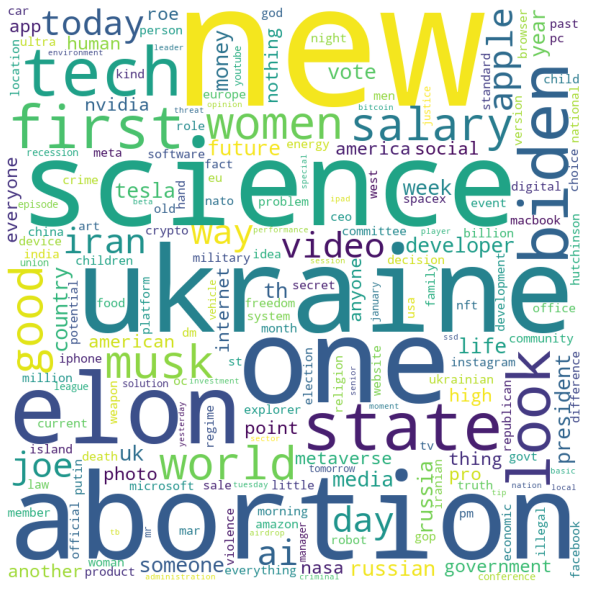

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_words = " ".join(set(df['Text_words'].explode()) - {np.nan})
all_words = " ".join(df['Text_words'].explode().value_counts().reset_index()['index'])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [13]:
nltk.FreqDist(df['Text_words'].explode()).most_common(20)

[("'", 2188),
 ('us', 2051),
 ('get', 2009),
 ('new', 1674),
 ('say', 1487),
 ('abortion', 1479),
 ('trump', 1477),
 ('war', 1450),
 ('like', 1435),
 ('make', 1392),
 ('go', 1336),
 ('people', 1332),
 ('s', 1285),
 ('science', 1134),
 ('time', 1117),
 ('right', 1108),
 ('workers', 1107),
 ('democrats', 1099),
 ('use', 1089),
 ('ukraine', 1085)]

## TF-IDF Search ---------------------------

In [14]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer

class TFIDFSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})

        self.tfidf = TfidfVectorizer(vocabulary=self.vocabulary)
        self.tfidf_tran=self.tfidf.fit_transform(df['Text_words'].apply(lambda x: ' '.join(x)))

    def get_vector(self, tokens):
        result = np.zeros((len(self.vocabulary)))
        x= self.tfidf.transform(tokens)
        for token in tokens:
            try:
                ind = self.vocabulary.index(token)
                result[ind]  = x[0, self.tfidf.vocabulary_[token]]
            except Exception as e:
                print(e)
                pass
        return result

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = preprocessor.clean_query(query)
        tokens = [token for token in tokens if token in self.vocabulary]
        print(tokens)
        q_df = pd.DataFrame(columns=['q_clean'])
        q_df.loc[0, 'q_clean'] = tokens

        d_cosines = []

        query_vector = self.get_vector(tokens)
        print(sum(query_vector))
        for d in self.tfidf_tran.A:
            d_cosines.append(self.cosine_sim(query_vector, d))

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

In [15]:
model = TFIDFSearch()
results = model.search(10, "Eluon musk")
results

['musk']
1.0


,index,text,words,Score
0,19210,Elon Musk replied to @elonmusk #SpaceX https:/...,"['elon', 'musk']",0.743127
1,19240,Elon Musk replied to @SpaceX #SpaceX https://t...,"['elon', 'musk']",0.743127
2,10729,RT @ExplainThisBob : When is Elon Musk?,"['elon', 'musk']",0.743127
3,19193,RT @EveryElonReply : Elon Musk replied to @elo...,"['elon', 'musk']",0.743127
4,19229,Elon Musk replied to @DJSnM #SpaceX https://t....,"['elon', 'musk']",0.743127
5,11319,To Elon Musk https://t.co/VcivwJOLtf,"['elon', 'musk']",0.743127
6,19228,RT @EveryElonReply : Elon Musk replied to @DJS...,"['elon', 'musk']",0.743127
7,10778,@ExplainThisBob Why is Elon Musk??,"['elon', 'musk']",0.743127
8,19201,Elon Musk replied to @Erdayastronaut #SpaceX h...,"['elon', 'musk']",0.743127
9,18952,Elon Musk replied to @Rainmaker1973 #SpaceX ht...,"['elon', 'musk']",0.743127


## Boolean Search ---------------------------

In [16]:
class BooleanSearch:
    def __init__(self):
        self.vocabulary = list(set(df['Text_words'].explode()) - {np.nan})
        self.vocabulary_index = {word: idx for idx, word in enumerate(self.vocabulary)}

        self.mat = np.zeros((len(df), len(self.vocabulary)), )

        for index, row in df.iterrows():
            for token in row['Text_words']:
                self.mat[index][self.vocabulary_index[token]] = 1


    def search(self, k, query):
        #print("Cosine Similarity")
        tokens = preprocessor.clean_query(query)
        query_vector = []
        for token in tokens:
            if token in self.vocabulary_index:
                query_vector.append(self.vocabulary_index[token])
        out = []
        for index, vec in enumerate(self.mat):
            flag = True
            for token_index in query_vector:
                if vec[token_index] == 0:
                    flag = False
                    break
            if flag:
                out.append(index)
            if len(out) == k:
                break
        print(out)
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])

        return a

In [18]:
model = BooleanSearch()
model.search(10, "Elooon Musk")

[8002, 8180, 8380, 8522, 8645, 10527, 10528, 10529, 10534, 10536]


,index,text,words
0,8002,@KenPaxtonTX Musk could solve the abortion con...,"['musk', 'could', 'solve', 'abortion', 'contro..."
1,8180,#ElonMusk is meeting #Twitter employees on Thu...,"['meet', 'employees', 'thursday', 'give', 'twi..."
2,8380,Tesla FSD Beta V.11 likely to be ready for wid...,"['tesla', 'fsd', 'beta', 'v', 'likely', 'ready..."
3,8522,RT @FreeElonNow : You can’t put a price on fre...,"['put', 'price', 'free', 'speech', 'unless', '..."
4,8645,"When @elonmusk starts running his mouff, y’all...","['start', 'run', 'mouff', 'need', 'remind', 'f..."
5,10527,"@author_tonylevy @Madiii03 Elon Musk is not ""g...","['elon', 'musk', 'great', 'company', 'especial..."
6,10528,RT @MarioNawfal : Introducing @ShiLLin_ViLLian...,"['introduce', 'panelist', 'space', 'hours', 's..."
7,10529,"RT @20W24 : Elon Musk said, Democrats are the ...","['elon', 'musk', 'say', 'democrats', 'party', ..."
8,10534,Why isn't Elon Musk sitting around and picking...,"['elon', 'musk', 'sit', 'around', 'pick', 'nos..."
9,10536,@SawaatMathiang @junub_bot Elon musk is close ...,"['elon', 'musk', 'close', 'us', 'gov', 'monopo..."


## FastText ---------------------------

In [19]:
import fasttext.util

class FastText:
    def __init__(self):
        fasttext.util.download_model('en', if_exists='ignore')  # English
        self.ft = fasttext.load_model("./cc.en.300.bin")
        
        self.text_vectors = []
        self.words_count = []
        for _, row in df.iterrows():
            self.words_count.append(len(row['Text_words']))
            self.text_vectors.append(self.tokens_to_vec(row['Text_words']))

    def tokens_to_vec(self, tokens):
        cur_vectors = []
        if len(tokens) == 0:
            return np.zeros(self.ft.get_dimension())
        for token in tokens:
            cur_vectors.append(self.ft.get_word_vector(token))
        return np.asarray(np.average(cur_vectors, axis=0, keepdims=True))[0]

    @staticmethod
    def cosine_sim(a, b):
        norm_a = np.linalg.norm(a)
        norm_b = np.linalg.norm(b)
        if norm_a == 0 or norm_b == 0:
            return 0
        cos_sim = np.dot(a, b)/(norm_a*norm_b)
        return cos_sim

    def search(self, k, query):
        tokens = preprocessor.clean_query(query)
        query_vector = self.tokens_to_vec(tokens)
        d_cosines = []
        print(tokens)
        for idx, d in enumerate(self.text_vectors):
            d_cosines.append(self.cosine_sim(d, query_vector))
            if self.words_count[idx] > 10:
                d_cosines[-1] += 0.2
            elif self.words_count[idx] > 5:
                d_cosines[-1] += 0.1

        out = np.array(d_cosines).argsort()[-k:][::-1]
        a = pd.DataFrame()
        for i, index in enumerate(out):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = d_cosines[int(index)]
        return a

## Transformer ---------------------------

In [17]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine

class TransformerSearch:
    def __init__(self, df):
        self.model = SentenceTransformer('all-MiniLM-L6-v2')
        self.preprocessor = Preprocessor()

        self.all_embeddings = []
        for tweet in tqdm(df.Text_words):
            joined_tweet = " ".join(tweet)
            tweet_embedding = self.model.encode(joined_tweet)
            self.all_embeddings.append(tweet_embedding)

        # with open('/content/gdrive/MyDrive/MIR-HW3-Transformer/all_embeddings.npy', 'wb') as f:
        #     np.save(f, self.all_embeddings)

        # self.all_embeddings = np.load("/content/gdrive/MyDrive/MIR-HW3-Transformer/all_embeddings.npy")

    def search(self, k, query):
        cleaned = self.preprocessor.clean_query(query)
        cleaned = ' '.join(cleaned)

        encoded_q = self.model.encode([cleaned])

        scores = np.array([(1-cosine(doc, encoded_q)) for doc in self.all_embeddings])
        tops = scores.argsort()[-k:][::-1]
        print(tops)


        a = pd.DataFrame()
        for i, index in enumerate(tops):
            a.loc[i, 'index'] = str(index)
            a.loc[i, 'text'] = df.iloc[index]['Text']
            a.loc[i, 'words'] = str(df.iloc[index]['Text_words'])
            a.loc[i, 'Score'] = scores[int(index)]
        return a

In [18]:
pd.set_option('display.max_colwidth', 150)

In [19]:
models = [TransformerSearch(df)]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 26363/26363 [03:20<00:00, 131.74it/s]


In [22]:
class Evaluator:
    queries = [
        "how to became full stack developer",
        "Microsoft Internet Explorer age",
        "Tesla price",
        "Macbook M2 Price",
        "Abortion rights",
        "Ukraine war",
        "Raisi",
        "Harry potter",
        "Covid vaccine",
        "Meta VR"
    ]

    def run(self):
        scores = np.zeros((len(self.queries),len(models)))
        for idxq, query in enumerate(self.queries):
            for idxm, model in enumerate(models):
                result = model.search(10, query)
                for idxr, row in result.iterrows():
                    print("-"*100)
                    print(">", query)
                    print(row['text'])
                    if input("Are result related to query?(y/n)").lower() == 'y':
                        scores[idxq][idxm] = 1/(idxr + 1)
                        break
        self.scores = scores
evaluator = Evaluator()
evaluator.run()

[16482 16562 20804 16323 16440 16417 16607 16342 16639 16489]
----------------------------------------------------------------------------------------------------
> how to became full stack developer
RT @PinakiLaskar : Full stack developer skills
#AI #IoT #IIoT #CX #MachineLearning #SelfDrivingCars #fashiontech #SmartCity #AutonomousVehicles #DataScience #BigData #Analytics #JavaScript #Serverless #Linux #RStats #Programming #Coding #NLP #Web3 #5G #Blockchain #Metaverse #100DaysofCode #NodeJS https://t.co/BBYTrN8g6b
Are result related to query?(y/n)y
[13315 13811 13613 13829 13571 13622 13794 13299 13307 13329]
----------------------------------------------------------------------------------------------------
> Microsoft Internet Explorer age
Microsoft to retire Internet Explorer after 27 years. https://t.co/a3YHsJ75Od #InternetExplorer #Microsoft
Are result related to query?(y/n)y
[26045 26271 25346 26092 25325 25741 25706 25337 26232 26229]
------------------------------------------

In [23]:
pd.DataFrame({
    "models": map(lambda x: x.__class__.__name__, models),
    "scores": evaluator.scores.mean(axis=0),
})

,models,scores
0,TransformerSearch,0.95
